In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [40]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 5
DOLLAR_THRESHOLD = "115009542m"

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "interm/resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"

In [41]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 2.22 ms, sys: 9.84 ms, total: 12.1 ms
Wall time: 10.9 ms


In [42]:
df.shape

(72013, 10)

In [43]:
df.head()

,open,high,low,close,volume,spread,return,log_return,fd_return,log_fd_return
timestamp,,,,,,,,,,
2024-01-15 06:35:00,1.096440,1.096615,1.096425,1.096595,9.697500e+11,0.000027,0.000160,0.000146,0.113814,0.009814
2024-01-15 06:40:00,1.096600,1.096620,1.096510,1.096595,5.448600e+11,0.000025,0.000000,0.000000,0.113773,0.009777
2024-01-15 06:45:00,1.096600,1.096605,1.096445,1.096525,7.287000e+11,0.000025,-0.000070,-0.000064,0.113687,0.009698
2024-01-15 06:50:00,1.096530,1.096625,1.096485,1.096545,8.230700e+11,0.000027,0.000020,0.000018,0.113715,0.009724
2024-01-15 06:55:00,1.096535,1.096545,1.096340,1.096400,9.327600e+11,0.000026,-0.000145,-0.000132,0.113565,0.009587


In [44]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'return',
       'log_return', 'fd_return', 'log_fd_return'],
      dtype='object')

## Apply Z Score Filter

In [45]:
def z_score_filter(
    closes: pd.Series,
    mean_window: int,
    std_window: int,
    z_score: float = 3,
) -> pd.DatetimeIndex:

    t_events = closes[
        closes
        >= closes.rolling(window=mean_window).mean()
        + z_score * closes.rolling(window=std_window).std()
    ].index
    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [46]:
closes = df['close']
mean_window = 100
std_window = 100
z_score = 2

In [47]:
z_score_events = z_score_filter(
    closes, 
    mean_window=mean_window, 
    std_window=std_window, 
    z_score=z_score
)

In [48]:
z_score_events

DatetimeIndex(['2024-01-17 01:15:00', '2024-01-17 10:05:00',
               '2024-01-17 10:10:00', '2024-01-17 11:40:00',
               '2024-01-17 20:50:00', '2024-01-17 20:55:00',
               '2024-01-17 21:00:00', '2024-01-17 21:10:00',
               '2024-01-18 01:00:00', '2024-01-18 01:05:00',
               ...
               '2024-12-30 11:30:00', '2024-12-30 11:35:00',
               '2024-12-30 11:40:00', '2024-12-30 11:45:00',
               '2024-12-30 11:50:00', '2024-12-30 11:55:00',
               '2024-12-30 12:00:00', '2024-12-30 12:05:00',
               '2024-12-30 12:10:00', '2024-12-30 12:15:00'],
              dtype='datetime64[ns]', name='timestamp', length=5465, freq=None)

## Visualization

In [49]:

rolling_mean = closes.rolling(window=mean_window).mean()
rolling_std = closes.rolling(window=std_window).std()
upper_bound = rolling_mean + z_score * rolling_std
lower_bound = rolling_mean - z_score * rolling_std

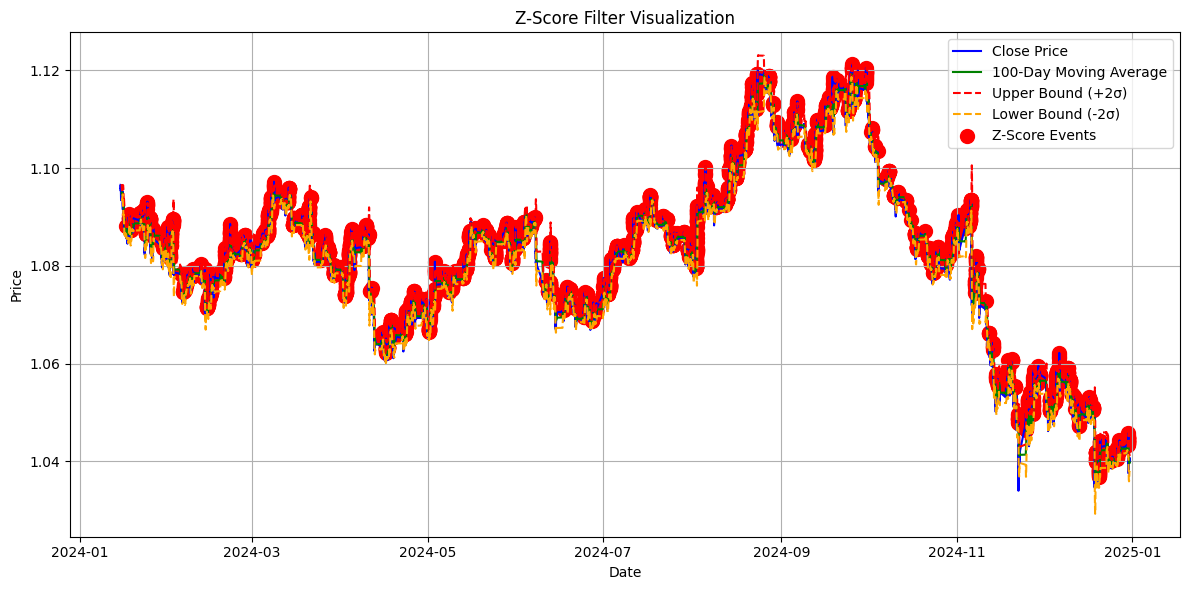

In [50]:
# 繪圖
plt.figure(figsize=(12, 6))
plt.plot(closes, label="Close Price", color="blue")
plt.plot(rolling_mean, label=f"{mean_window}-Day Moving Average", color="green")
plt.plot(upper_bound, label=f"Upper Bound (+{z_score}σ)", color="red", linestyle="--")
plt.plot(lower_bound, label=f"Lower Bound (-{z_score}σ)", color="orange", linestyle="--")
plt.scatter(
    z_score_events,
    closes[z_score_events],
    color="red",
    marker="o",
    s=100,
    label="Z-Score Events",
)
plt.title("Z-Score Filter Visualization")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save To Drive

In [51]:
EVENT_NAME = f"Z-SCORE-W{mean_window}-{z_score}Z"
EVENT_PATH = EVENTS_DIR / f"{RESAMPLED_NAME}_{EVENT_NAME}.pkl"

In [52]:
EVENT_PATH

PosixPath('../data/interm/events/USDJPY-5m-20240101-20241231_Z-SCORE-W100-2Z.pkl')

In [53]:
z_score_events.to_series().to_pickle(EVENT_PATH)